Step 1: Import Libraries and Read the Dataset

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import stats
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.neural_network import MLPClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Project - Churn Prediction/BankChurners1.csv')

Step 2: Exploratory Data Analysis (EDA)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float

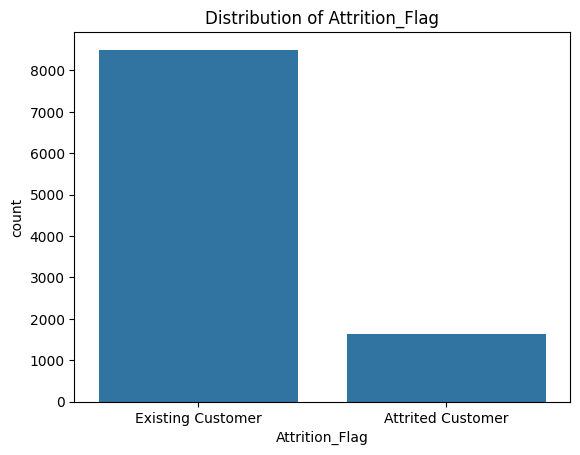

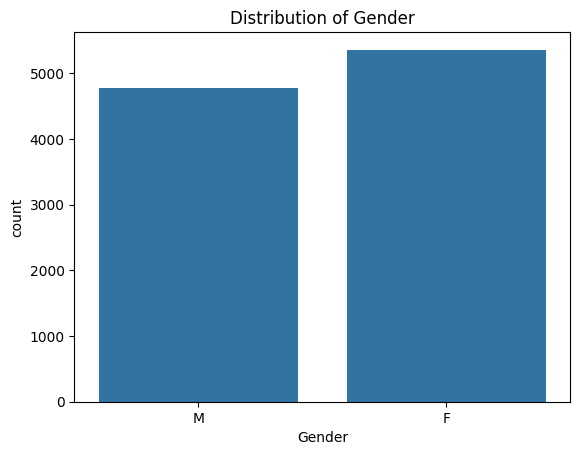

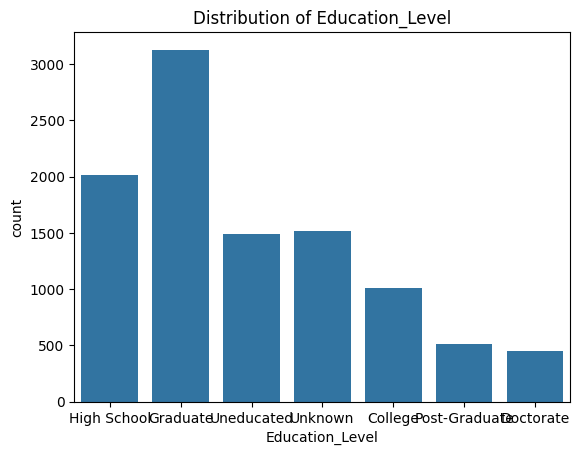

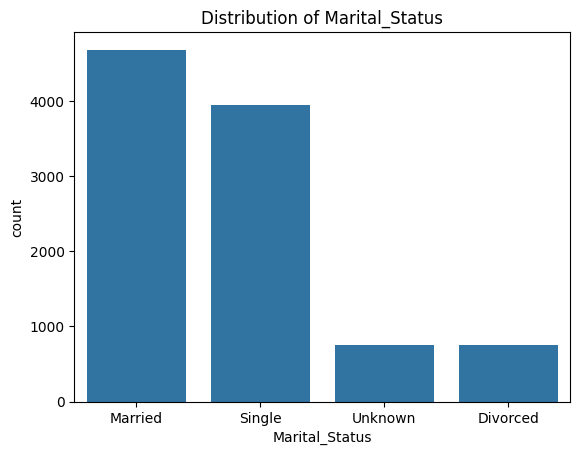

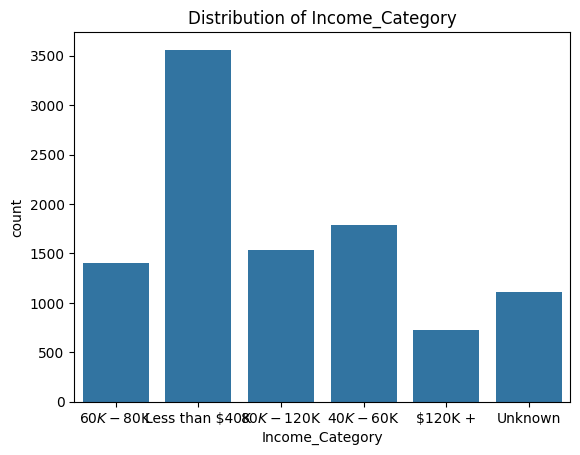

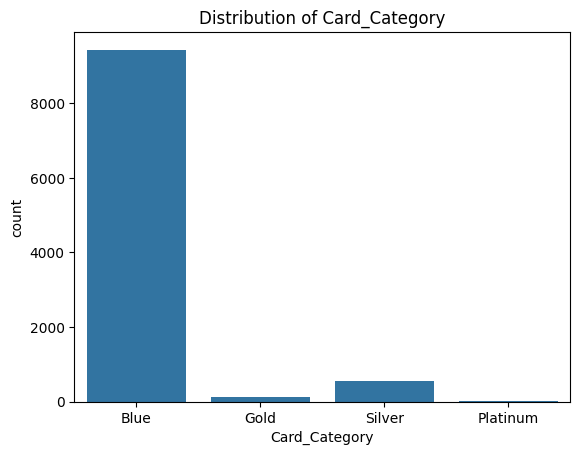

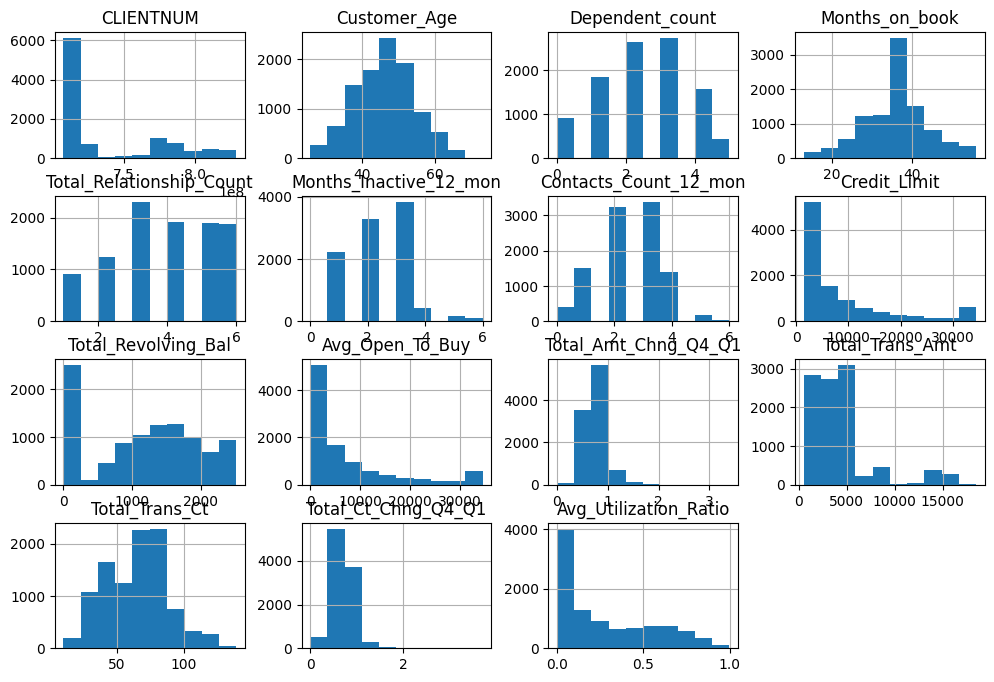

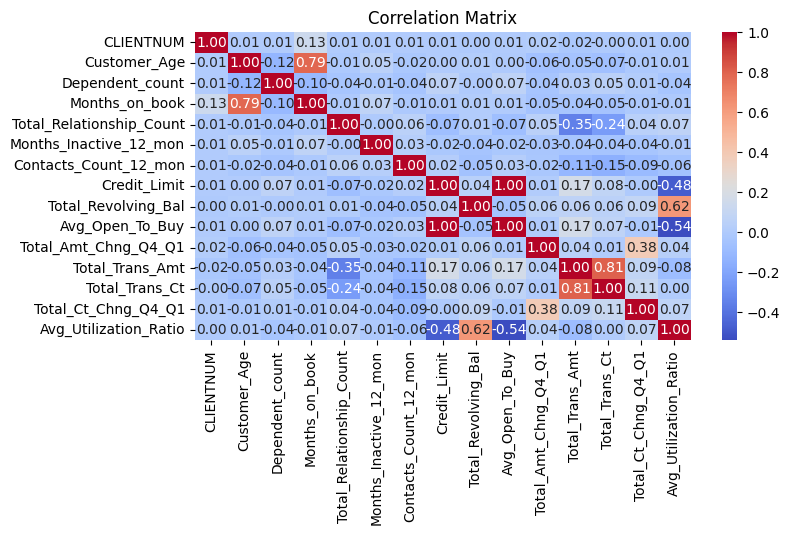

In [ ]:
# Basic information about the dataset
print("Dataset Info:")
dataset.info()

# Summary statistics
print("\nSummary Statistics:")
print(dataset.describe())

# Checking for missing values
print("\nMissing Values:")
print(dataset.isnull().sum())

# Checking for unique values and distribution in categorical columns
categorical_columns = ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
for col in categorical_columns:
    print(f"\nValue Counts for {col}:")
    print(dataset[col].value_counts())

# Plot distributions for categorical features
for col in categorical_columns:
    sns.countplot(x=col, data=dataset)
    plt.title(f'Distribution of {col}')
    plt.show()

# Data distribution in all columns
dataset.hist(figsize=(12,8))
plt.show()
# Correlation matrix for numerical features
numerical_columns = dataset.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = dataset[numerical_columns].corr()

# Heatmap of correlations
plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# # data analysis for outliers using z-score and IQR analysis
# # use stats for z-score on numerical columns
numerical_columns = dataset.select_dtypes(include=['int64', 'float64']).columns
z_score = np.abs(stats.zscore(dataset[numerical_columns]))
threshold = 3
outliers = np.where(z_score > threshold)

# # treat outliers
# dataset = dataset.drop(outliers[0])

# # use stats for IQR on numerical features
Q1 = dataset[numerical_columns].quantile(0.25)
Q3 = dataset[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# dataset = dataset[(dataset[numerical_columns] >= lower_bound) & (dataset[numerical_columns] <= upper_bound)]

Step 3: Data Preprocessing

(14,)
(10127, 20)


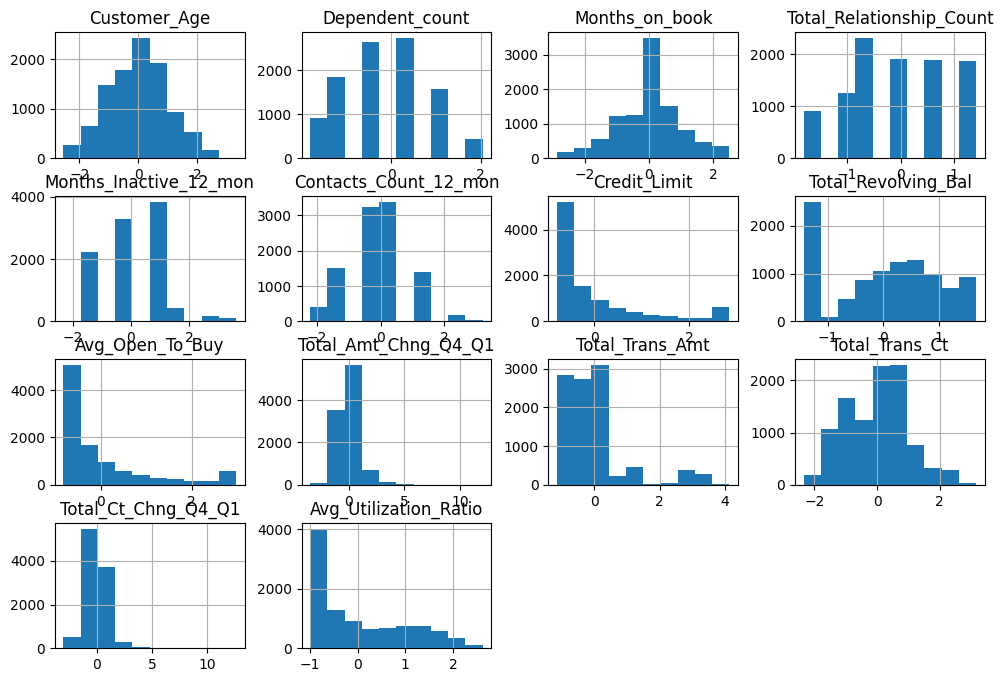

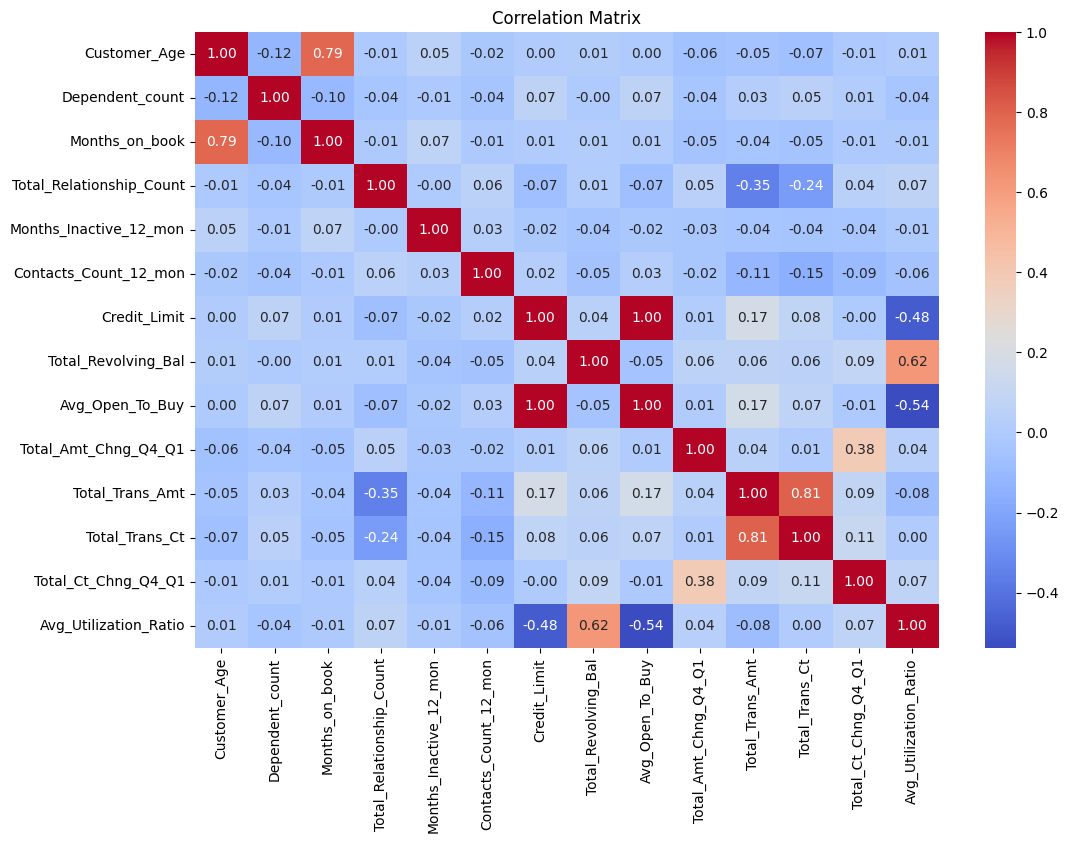

In [ ]:
# Drop the Customer ID column as it is not useful for modeling
dataset = dataset.drop(columns=['CLIENTNUM'])

# Normalize the numerical features
numerical_columns = dataset.select_dtypes(include=['int64', 'float64']).columns
print(numerical_columns.shape)
# scaler = MinMaxScaler()
# dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

# Standardize the numerical features
scaler = StandardScaler()
dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])
print(dataset.shape)

# Data distribution in all columns
dataset.hist(figsize=(12,8))
plt.show()
# Correlation matrix for numerical features
numerical_columns = dataset.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = dataset[numerical_columns].corr()

# Heatmap of correlations
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(10127, 20)
(10127, 22)
(10127, 22)

Class Distribution:
Attrition_Flag
1    8500
0    1627
Name: count, dtype: int64


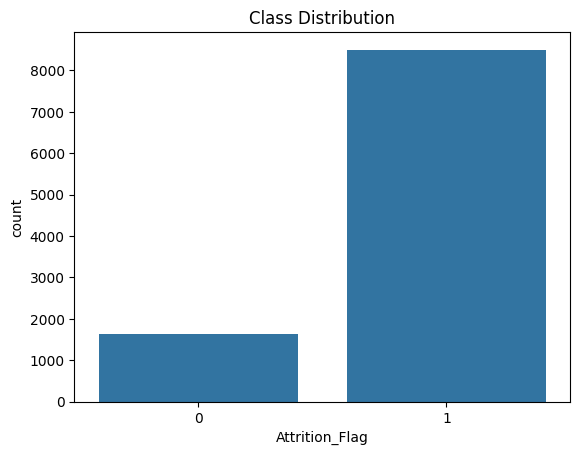

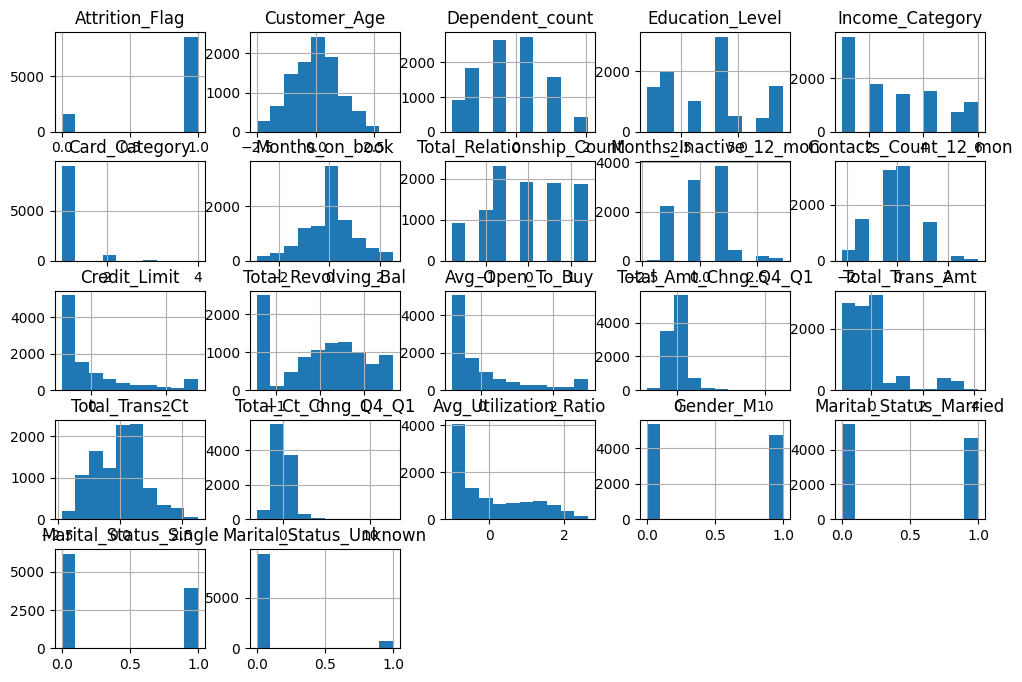

In [ ]:
# # Drop the Customer ID column as it is not useful for modeling
# dataset = dataset.drop(columns=['CLIENTNUM'])

# Encoding categorical variables
# OneHotEncoding for 'Gender' and 'Marital_Status'
onehot_cols = ['Gender', 'Marital_Status']
onehot_encoder = OneHotEncoder(sparse=False, drop='first')
encoded_onehot = pd.DataFrame(onehot_encoder.fit_transform(dataset[onehot_cols]), columns=onehot_encoder.get_feature_names_out(onehot_cols))
print(dataset.shape)
dataset = pd.concat([dataset.drop(columns=onehot_cols), encoded_onehot], axis=1)
print(dataset.shape)

# LabelEncoding for 'Attrition_Flag' (target variable)
label_encoder = LabelEncoder()
dataset['Attrition_Flag'] = label_encoder.fit_transform(dataset['Attrition_Flag'])

# Ordinal Encoding for 'Education_Level', 'Income_Category', 'Card_Category'
ordinal_mappings = {
    'Education_Level': {'Uneducated': 1, 'High School': 2, 'College': 3, 'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6, 'Unknown': 7},
    'Income_Category': {'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5, 'Unknown': 6},
    'Card_Category': {'Blue': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}
}
for col, mapping in ordinal_mappings.items():
    dataset[col] = dataset[col].map(mapping)
print(dataset.shape)
# Checking the class distribution
print("\nClass Distribution:")
print(dataset['Attrition_Flag'].value_counts())
# plot class distribution
sns.countplot(x='Attrition_Flag', data=dataset)
plt.title('Class Distribution')
plt.show()

# Data distribution in all columns
dataset.hist(figsize=(12,8))
plt.show()


(22,)


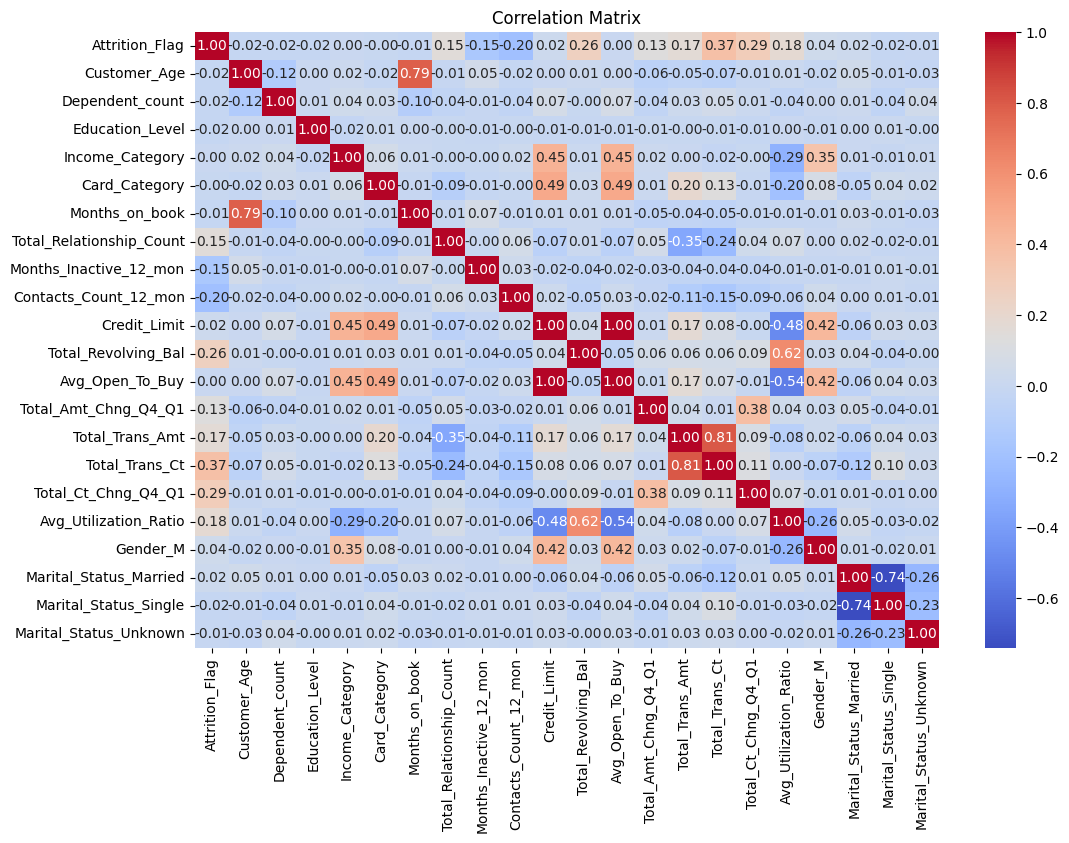

Credit_Limit            Avg_Open_To_Buy          0.995981
Total_Trans_Amt         Total_Trans_Ct           0.807192
Customer_Age            Months_on_book           0.788912
Marital_Status_Married  Marital_Status_Single    0.741185
Total_Revolving_Bal     Avg_Utilization_Ratio    0.624022
Avg_Open_To_Buy         Avg_Utilization_Ratio    0.538808
Card_Category           Credit_Limit             0.492446
                        Avg_Open_To_Buy          0.489985
Credit_Limit            Avg_Utilization_Ratio    0.482965
Income_Category         Credit_Limit             0.446349
dtype: float64


In [ ]:
# Correlation matrix for numerical features - After data preprocess
numerical_columns = dataset.select_dtypes(include=['int64', 'float64']).columns
print(numerical_columns.shape)
corr_matrix = dataset[numerical_columns].corr()

# Heatmap of correlations
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Get the absolute values of correlations
abs_correlation_matrix = corr_matrix.abs()

# Get the upper triangle of the correlation matrix (excluding diagonal)
upper_triangle = abs_correlation_matrix.where(np.triu(np.ones(abs_correlation_matrix.shape), k=1).astype(bool))

# Find the pairs of variables with the highest correlations
highest_correlations = upper_triangle.stack().nlargest(10)

# Print the pairs of variables with the highest correlations
print(highest_correlations)


Highly correlated pairs:
[('Customer_Age', 'Months_on_book'), ('Credit_Limit', 'Avg_Open_To_Buy'), ('Total_Revolving_Bal', 'Avg_Utilization_Ratio'), ('Total_Trans_Amt', 'Total_Trans_Ct')]
Columns removed:
{'Total_Trans_Amt', 'Credit_Limit', 'Total_Revolving_Bal', 'Customer_Age'}
(11,)


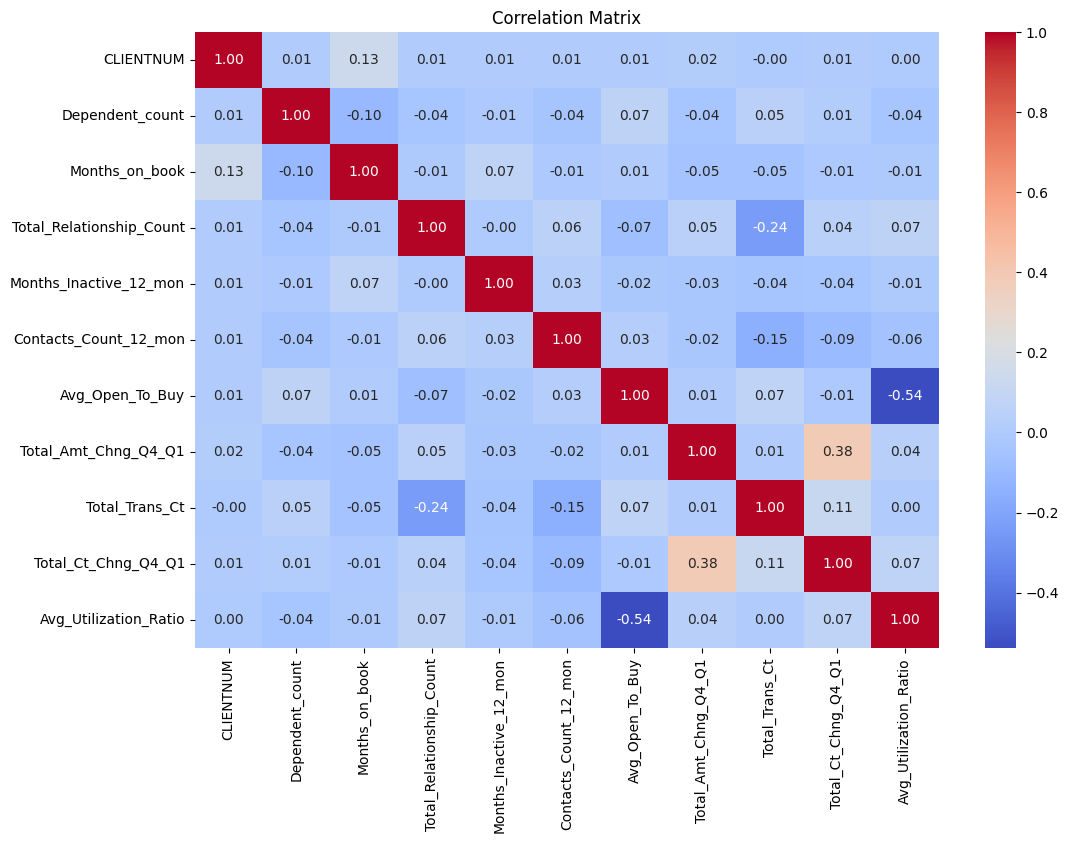

In [ ]:
# Setting threshold for considering a correlation as high
threshold = 0.60

# Pairs of features with correlation greater than the threshold
high_corr_pairs = np.where(np.abs(corr_matrix) > threshold)
high_corr_pairs = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_pairs) if x != y and x < y]
print("Highly correlated pairs:")
print(high_corr_pairs)

# Create a set to hold the columns to be removed
columns_to_remove = set()

for (col1, col2) in high_corr_pairs:
    # Add one of the columns to the removal set. Here, we are arbitrarily choosing the first column in the pair.
    # trsnaform this feature instead of removing it
    # feature engineering

    columns_to_remove.add(col1)

# Remove the identified columns from the dataset
dataset = dataset.drop(columns=columns_to_remove)

print("Columns removed:")
print(columns_to_remove)

# Correlation matrix for numerical features - After removing high-correlated features
numerical_columns = dataset.select_dtypes(include=['int64', 'float64']).columns
print(numerical_columns.shape)
corr_matrix = dataset[numerical_columns].corr()

# Heatmap of correlations
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


Step 4: Train-Test Split

In [ ]:
# Split dataset into features and target
X = dataset.drop(columns=['Attrition_Flag'])
y = dataset['Attrition_Flag']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


Step 5: Handling Class Imbalance

We tried to handle the class imbalnce using two different ways: Undersampling the majority class and oversampling the minority class

Step 6: Feature Scaling

In [ ]:
# dataset)
X_train_scaled_normal = X_train
X_test_scaled_normal = X_test
print(X_train_scaled_normal.shape)
print(X_test_scaled_normal.shape)


(8101, 16)
(2026, 16)


Step 7: Baseline Model and Performance Evaluation

Baseline Model - Training Score: 0.89
Baseline Model - Testing Score: 0.89

Classification Report (Baseline Model):
              precision    recall  f1-score   support

           0       0.73      0.50      0.59       325
           1       0.91      0.96      0.94      1701

    accuracy                           0.89      2026
   macro avg       0.82      0.73      0.76      2026
weighted avg       0.88      0.89      0.88      2026



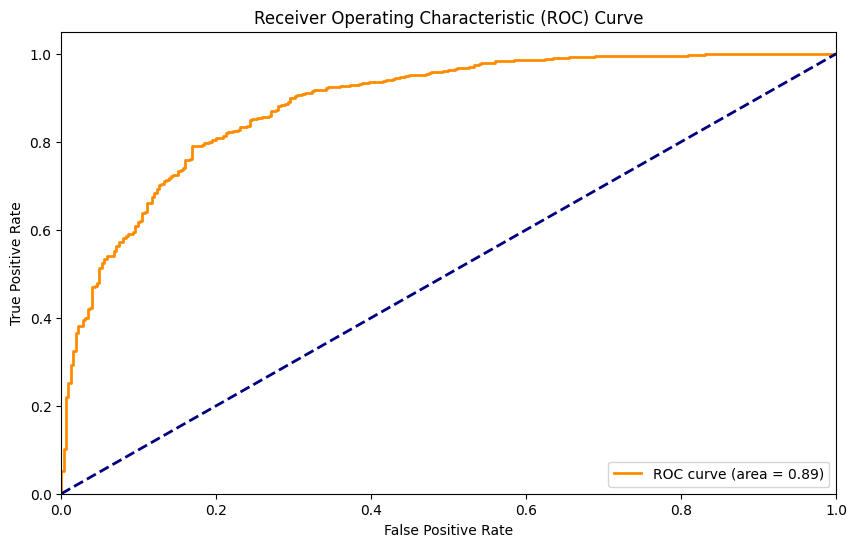

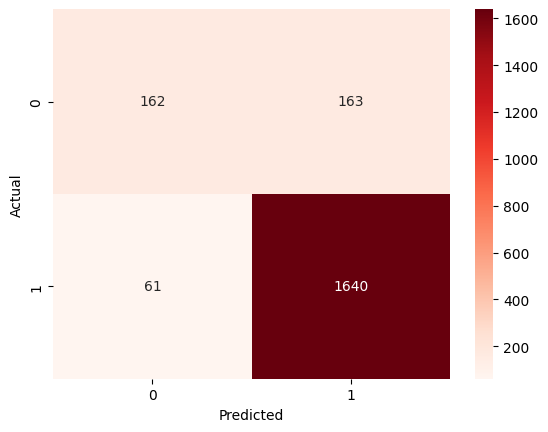

In [ ]:
# Logistic Regression as a baseline model
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Training and testing scores
train_score = baseline_model.score(X_train, y_train)
test_score = baseline_model.score(X_test, y_test)
print(f'Baseline Model - Training Score: {train_score:.2f}')
print(f'Baseline Model - Testing Score: {test_score:.2f}')

# Predictions and classification report
y_pred = baseline_model.predict(X_test)
print("\nClassification Report (Baseline Model):")
print(classification_report(y_test, y_pred))

# ROC Curve and AUC
y_pred_proba = baseline_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# confusion matrix with colors
# import confusion_matrix from sklearn.metrics
from sklearn.metrics import confusion_matrix

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Step 8: Model Comparison and Stacking

In [ ]:
# Initialize models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(probability=True, random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train_scaled_normal, y_train)
    y_pred = model.predict(X_test_scaled_normal)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test_scaled_normal)[:, 1])
    }
    # report for each model
    # print(f"\nClassification Report ({name}): " )
    # print(classification_report(y_test, y_pred))

# print all the results one by one
# Print model comparison
print("\nModel Comparison:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.2f}")


# Stacking Classifier
stacking_model = StackingClassifier(
    classifiers=[
        models['K-Nearest Neighbors'], models['Support Vector Classifier'],
        models['Gaussian Naive Bayes'], models['Decision Tree'], models['Random Forest'],
        models['XGBoost'], models['AdaBoost'], models['Gradient Boosting'], models['CatBoost'], models['LightGBM']
    ],
    meta_classifier=LogisticRegression(random_state=42)
)

# Train the stacking model
stacking_model.fit(X_train_scaled_normal, y_train)

# Evaluate the stacking model
y_pred_stack = stacking_model.predict(X_test_scaled_normal)
stacking_results = {
    'Accuracy': accuracy_score(y_test, y_pred_stack),
    'Precision': precision_score(y_test, y_pred_stack),
    'Recall': recall_score(y_test, y_pred_stack),
    'F1 Score': f1_score(y_test, y_pred_stack),
    'ROC AUC': roc_auc_score(y_test, stacking_model.predict_proba(X_test_scaled_normal)[:, 1])
}

# print(f"\nClassification Report (Stacking): " )
# print(classification_report(y_test, y_pred_stack))

print("\nStacking Model Performance:")
for metric, score in stacking_results.items():
    print(f"  {metric}: {score:.2f}")


[LightGBM] [Info] Number of positive: 6799, number of negative: 1302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.839279 -> initscore=1.652874
[LightGBM] [Info] Start training from score 1.652874

Model Comparison:

K-Nearest Neighbors:
  Accuracy: 0.89
  Precision: 0.91
  Recall: 0.96
  F1 Score: 0.94
  ROC AUC: 0.87

Support Vector Classifier:
  Accuracy: 0.91
  Precision: 0.92
  Recall: 0.98
  F1 Score: 0.95
  ROC AUC: 0.92

Gaussian Naive Bayes:
  Accuracy: 0.88
  Precision: 0.91
  Recall: 0.95
  F1 Score: 0.93
  ROC AUC: 0.88

Decision Tree:
  Accuracy: 0.89
  Precision: 0.94
  Recall: 0.93
  F1 Score: 0.93
  ROC AUC: 0.81

Random

Step 9: Visualization of Performance Curves

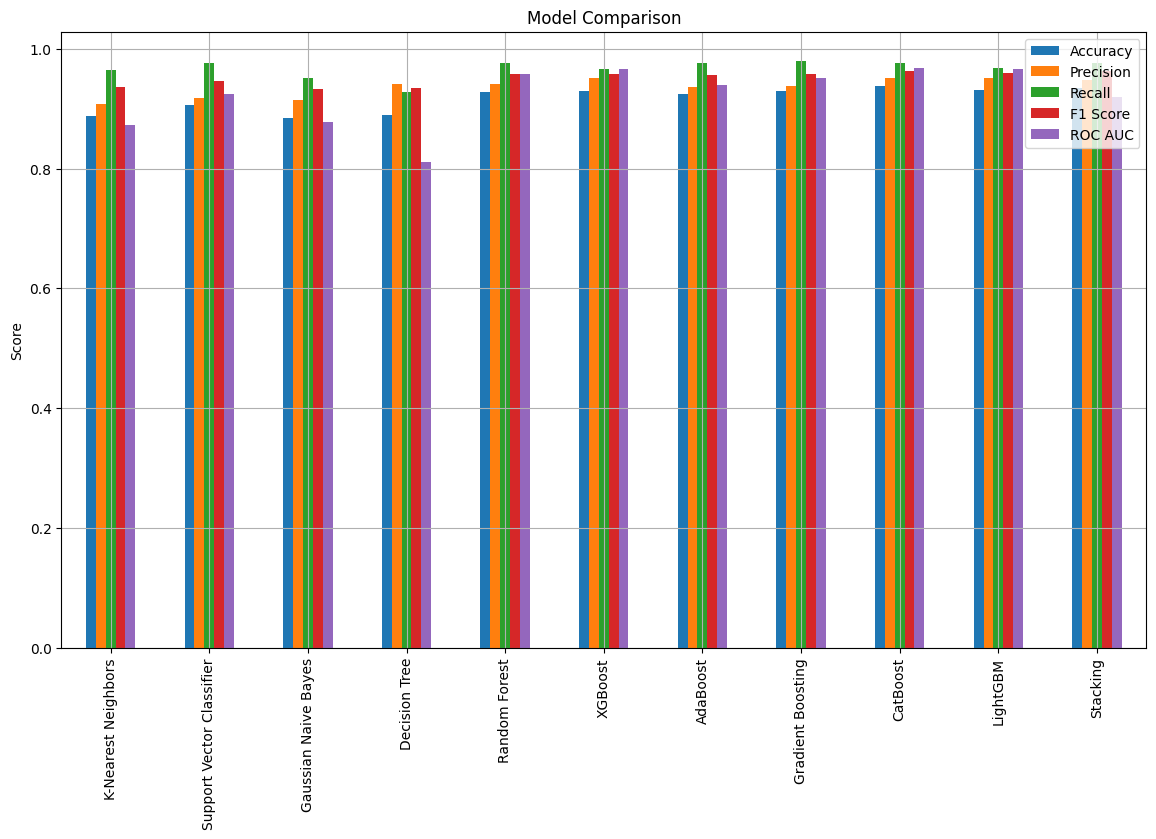

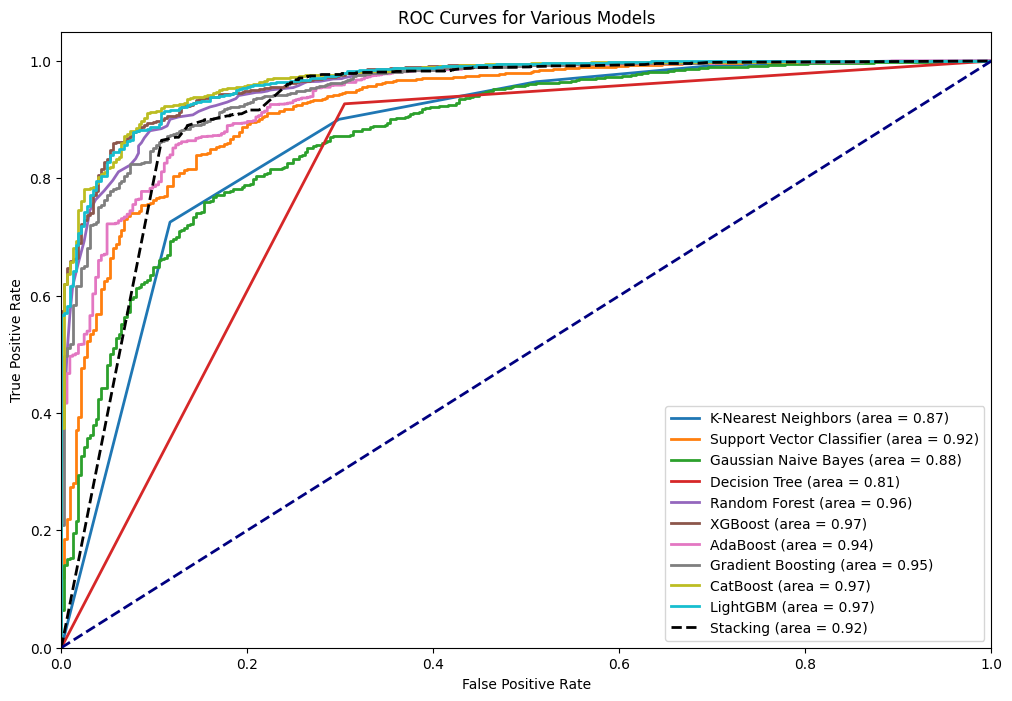

In [ ]:
# Collecting performance metrics for all models
performance_metrics = pd.DataFrame(results).T
# add stacking_results tothe performance_metrics as a column
performance_metrics.loc['Stacking'] = stacking_results

# Plotting the performance metrics
performance_metrics.plot(kind='bar', figsize=(14,8), title='Model Comparison', grid=True)
plt.ylabel('Score')
plt.show()

# Plotting ROC Curves for all models
plt.figure(figsize=(12,8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled_normal)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

# Adding ROC curve for stacking model
y_pred_proba_stack = stacking_model.predict_proba(X_test_scaled_normal)[:,1]
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_pred_proba_stack)
roc_auc_stack = roc_auc_score(y_test, y_pred_proba_stack)
plt.plot(fpr_stack, tpr_stack, lw=2, label=f'Stacking (area = {roc_auc_stack:.2f})', color='black', linestyle='--')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc="lower right")
plt.show()


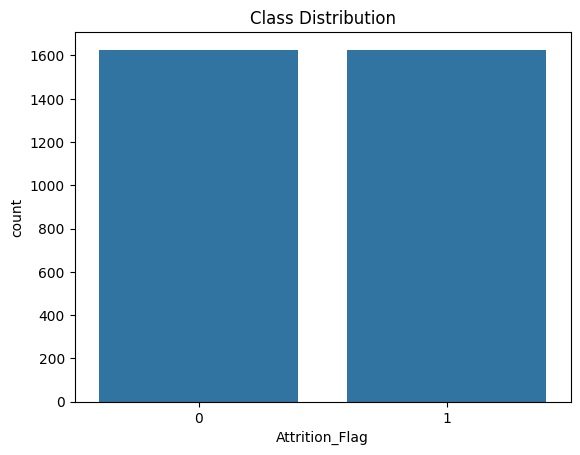


Class Distribution After Random Under-sampling:
Attrition_Flag
1    1325
0    1278
Name: count, dtype: int64
(2603, 16)
(651, 16)


In [ ]:
# Applying Random Under-sampling to handle class imbalance
rus = RandomUnderSampler(random_state=42)
X_train_sampling, y_train_sampling = rus.fit_resample(X, y)
# Convert y_train_sampling to a DataFrame
y_train_sampling_df = pd.DataFrame(y_train_sampling)

# Plot the class distribution using the DataFrame
sns.countplot(x='Attrition_Flag', data=y_train_sampling_df)
plt.title('Class Distribution')
plt.show()
# dataset split
X_train_sampling, X_test_sampling, y_train_sampling, y_test_sampling = train_test_split(X_train_sampling, y_train_sampling, test_size=0.20, random_state=42)

# Verifying the new class distribution
print("\nClass Distribution After Random Under-sampling:")
print(pd.Series(y_train_sampling).value_counts())

# dataset
X_train_scaled_sampling = X_train_sampling
X_test_scaled_sampling = X_test_sampling
print(X_train_scaled_sampling.shape)
print(X_test_scaled_sampling.shape)


In [ ]:
# Initialize models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(probability=True, random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train_scaled_sampling, y_train_sampling)
    y_pred = model.predict(X_test_scaled_sampling)
    results[name] = {
        'Accuracy': accuracy_score(y_test_sampling, y_pred),
        'Precision': precision_score(y_test_sampling, y_pred),
        'Recall': recall_score(y_test_sampling, y_pred),
        'F1 Score': f1_score(y_test_sampling, y_pred),
        'ROC AUC': roc_auc_score(y_test_sampling, model.predict_proba(X_test_scaled_sampling)[:, 1])
    }
    # print(f"\nClassification Report ({name}): " )
    # print(classification_report(y_test_sampling, y_pred))

# Print model comparison
print("\nModel Comparison:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.2f}")

# Stacking Classifier
stacking_model = StackingClassifier(
    classifiers=[
        models['K-Nearest Neighbors'], models['Support Vector Classifier'],
        models['Gaussian Naive Bayes'], models['Decision Tree'], models['Random Forest'],
        models['XGBoost'], models['AdaBoost'], models['Gradient Boosting'], models['CatBoost'], models['LightGBM']
    ],
    meta_classifier=LogisticRegression(random_state=42)
)

# Train the stacking model
stacking_model.fit(X_train_scaled_sampling, y_train_sampling)

# Evaluate the stacking model
y_pred_stack = stacking_model.predict(X_test_scaled_sampling)
stacking_results = {
    'Accuracy': accuracy_score(y_test_sampling, y_pred_stack),
    'Precision': precision_score(y_test_sampling, y_pred_stack),
    'Recall': recall_score(y_test_sampling, y_pred_stack),
    'F1 Score': f1_score(y_test_sampling, y_pred_stack),
    'ROC AUC': roc_auc_score(y_test_sampling, stacking_model.predict_proba(X_test_scaled_sampling)[:, 1])
}
# print(f"\nClassification Report (Stacking): " )
# print(classification_report(y_test_sampling, y_pred_stack))

print("\nStacking Model Performance:")
for metric, score in stacking_results.items():
    print(f"  {metric}: {score:.2f}")


[LightGBM] [Info] Number of positive: 1325, number of negative: 1278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 2603, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509028 -> initscore=0.036116
[LightGBM] [Info] Start training from score 0.036116

Model Comparison:

K-Nearest Neighbors:
  Accuracy: 0.81
  Precision: 0.78
  Recall: 0.82
  F1 Score: 0.80
  ROC AUC: 0.90

Support Vector Classifier:
  Accuracy: 0.85
  Precision: 0.82
  Recall: 0.87
  F1 Score: 0.84
  ROC AUC: 0.92

Gaussian Naive Bayes:
  Accuracy: 0.81
  Precision: 0.78
  Recall: 0.83
  F1 Score: 0.80
  ROC AUC: 0.88

Decision Tree:
  Accuracy: 0.80
  Precision: 0.78
  Recall: 0.81
  F1 Score: 0.79
  ROC AUC: 0.80

Random Forest:
  Accuracy: 0.88
  Precision: 0.84
  Recall: 0.91
  F1 

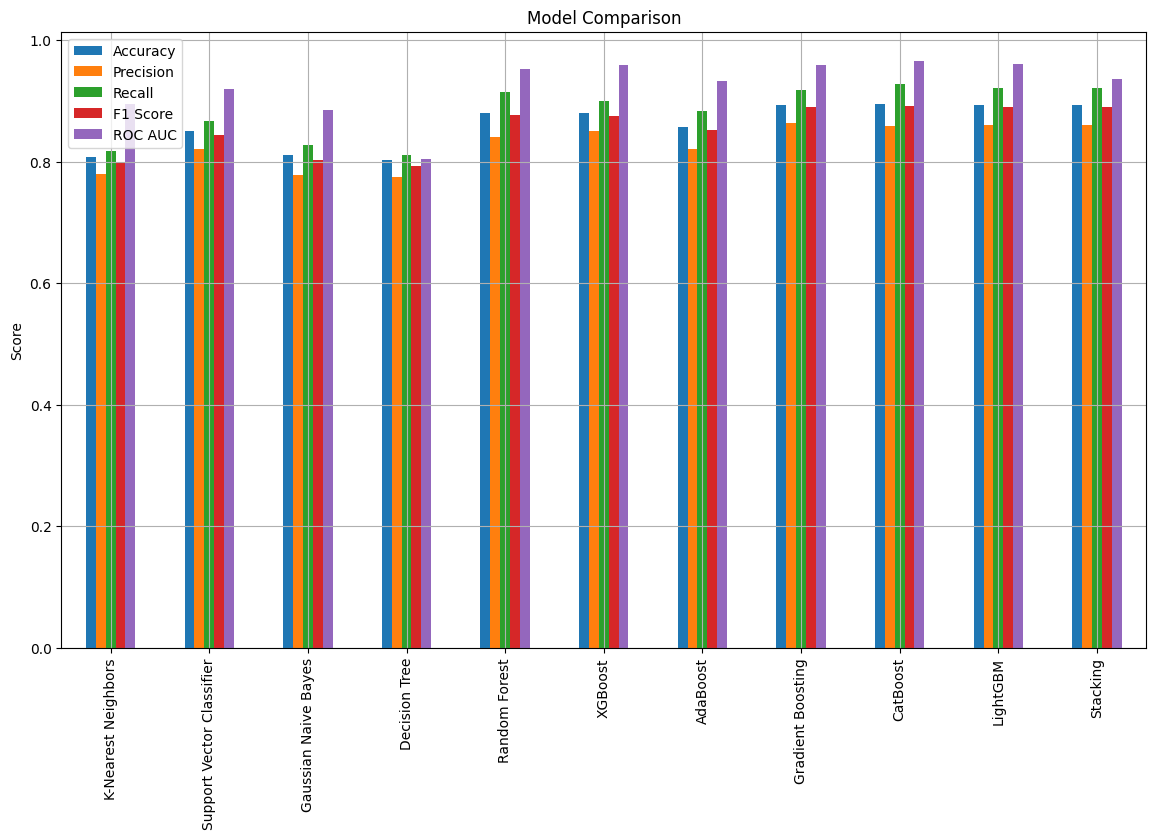

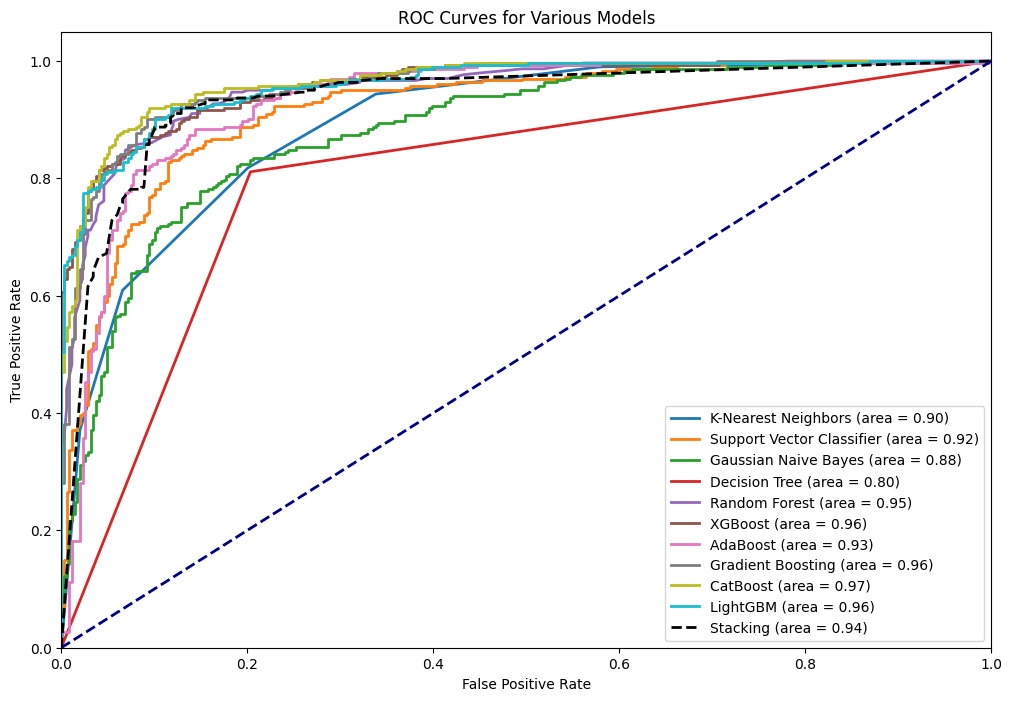

In [ ]:
# Collecting performance metrics for all models
performance_metrics = pd.DataFrame(results).T
# add stacking_results tothe performance_metrics as a column
performance_metrics.loc['Stacking'] = stacking_results

# Plotting the performance metrics
performance_metrics.plot(kind='bar', figsize=(14,8), title='Model Comparison', grid=True)
plt.ylabel('Score')
plt.show()

# Plotting ROC Curves for all models
plt.figure(figsize=(12,8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled_sampling)[:,1]
    fpr, tpr, _ = roc_curve(y_test_sampling, y_pred_proba)
    roc_auc = roc_auc_score(y_test_sampling, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

# Adding ROC curve for stacking model
y_pred_proba_stack = stacking_model.predict_proba(X_test_scaled_sampling)[:,1]
fpr_stack, tpr_stack, _ = roc_curve(y_test_sampling, y_pred_proba_stack)
roc_auc_stack = roc_auc_score(y_test_sampling, y_pred_proba_stack)
plt.plot(fpr_stack, tpr_stack, lw=2, label=f'Stacking (area = {roc_auc_stack:.2f})', color='black', linestyle='--')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc="lower right")
plt.show()


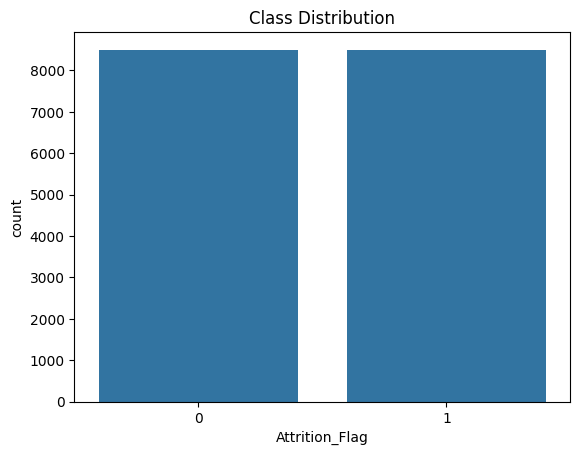


Class Distribution After SMOTE:
Attrition_Flag
1    6824
0    6776
Name: count, dtype: int64
(13600, 16)
(3400, 16)


In [ ]:
# Applying SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X, y)
# Convert y_train_sampling to a DataFrame
y_train_sampling_df = pd.DataFrame(y_train_smote)

# Plot the class distribution using the DataFrame
sns.countplot(x='Attrition_Flag', data=y_train_sampling_df)
plt.title('Class Distribution')
plt.show()
# dataset split
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_train_smote, y_train_smote, test_size=0.20, random_state=42)

# Verifying the new class distribution
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# dataset
X_train_scaled_smote = X_train_smote
X_test_scaled_smote = X_test_smote
# X_train_scaled_smote = scaler.fit_transform(X_train_smote)    # SMOTE for class-imbalce
# X_test_scaled_smote = scaler.fit_transform(X_test_smote)
print(X_train_scaled_smote.shape)
print(X_test_scaled_smote.shape)

[LightGBM] [Info] Number of positive: 6824, number of negative: 6776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3332
[LightGBM] [Info] Number of data points in the train set: 13600, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501765 -> initscore=0.007059
[LightGBM] [Info] Start training from score 0.007059


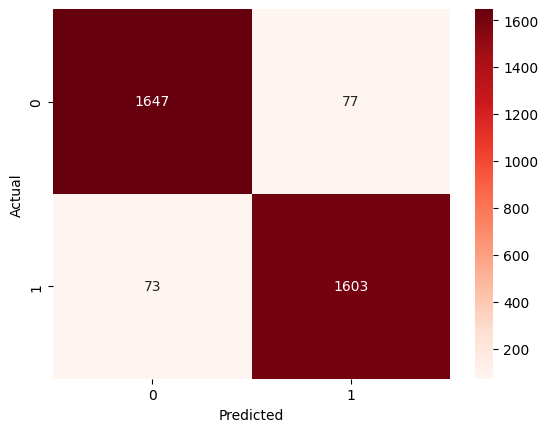


Model Comparison:

K-Nearest Neighbors:
  Accuracy: 0.91
  Precision: 0.99
  Recall: 0.83
  F1 Score: 0.90
  ROC AUC: 0.97

Support Vector Classifier:
  Accuracy: 0.91
  Precision: 0.92
  Recall: 0.89
  F1 Score: 0.90
  ROC AUC: 0.97

Gaussian Naive Bayes:
  Accuracy: 0.84
  Precision: 0.84
  Recall: 0.83
  F1 Score: 0.84
  ROC AUC: 0.91

Decision Tree:
  Accuracy: 0.92
  Precision: 0.92
  Recall: 0.92
  F1 Score: 0.92
  ROC AUC: 0.92

Random Forest:
  Accuracy: 0.97
  Precision: 0.97
  Recall: 0.96
  F1 Score: 0.97
  ROC AUC: 0.99

XGBoost:
  Accuracy: 0.97
  Precision: 0.96
  Recall: 0.97
  F1 Score: 0.97
  ROC AUC: 1.00

AdaBoost:
  Accuracy: 0.92
  Precision: 0.92
  Recall: 0.92
  F1 Score: 0.92
  ROC AUC: 0.98

CatBoost:
  Accuracy: 0.97
  Precision: 0.96
  Recall: 0.97
  F1 Score: 0.97
  ROC AUC: 1.00

LightGBM:
  Accuracy: 0.96
  Precision: 0.96
  Recall: 0.97
  F1 Score: 0.96
  ROC AUC: 1.00

Gradient Boosting:
  Accuracy: 0.96
  Precision: 0.95
  Recall: 0.96
  F1 Score: 0.96

In [ ]:
# Initialize models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(probability=True, random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train_scaled_smote, y_train_smote)
    y_pred = model.predict(X_test_scaled_smote)
    results[name] = {
        'Accuracy': accuracy_score(y_test_smote, y_pred),
        'Precision': precision_score(y_test_smote, y_pred),
        'Recall': recall_score(y_test_smote, y_pred),
        'F1 Score': f1_score(y_test_smote, y_pred),
        'ROC AUC': roc_auc_score(y_test_smote, model.predict_proba(X_test_scaled_smote)[:, 1])
    }
    # print(f"\nClassification Report ({name}): " )
    # print(classification_report(y_test_smote, y_pred))
# compute confusion matrix
cm = confusion_matrix(y_test_smote, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print model comparison
print("\nModel Comparison:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.2f}")

# Stacking Classifier
stacking_model = StackingClassifier(
    classifiers=[
        models['K-Nearest Neighbors'], models['Support Vector Classifier'],
        models['Gaussian Naive Bayes'], models['Decision Tree'], models['Random Forest'],
        models['XGBoost'], models['AdaBoost'], models['Gradient Boosting'], models['CatBoost'], models['LightGBM']
    ],
    meta_classifier=LogisticRegression(random_state=42)
)

# Train the stacking model
stacking_model.fit(X_train_scaled_smote, y_train_smote)

# Evaluate the stacking model
y_pred_stack = stacking_model.predict(X_test_scaled_smote)
stacking_results = {
    'Accuracy': accuracy_score(y_test_smote, y_pred_stack),
    'Precision': precision_score(y_test_smote, y_pred_stack),
    'Recall': recall_score(y_test_smote, y_pred_stack),
    'F1 Score': f1_score(y_test_smote, y_pred_stack),
    'ROC AUC': roc_auc_score(y_test_smote, stacking_model.predict_proba(X_test_scaled_smote)[:, 1])
}
# print(f"\nClassification Report (Stacking): " )
# print(classification_report(y_test_smote, y_pred_stack))

print("\nStacking Model Performance:")
for metric, score in stacking_results.items():
    print(f"  {metric}: {score:.2f}")

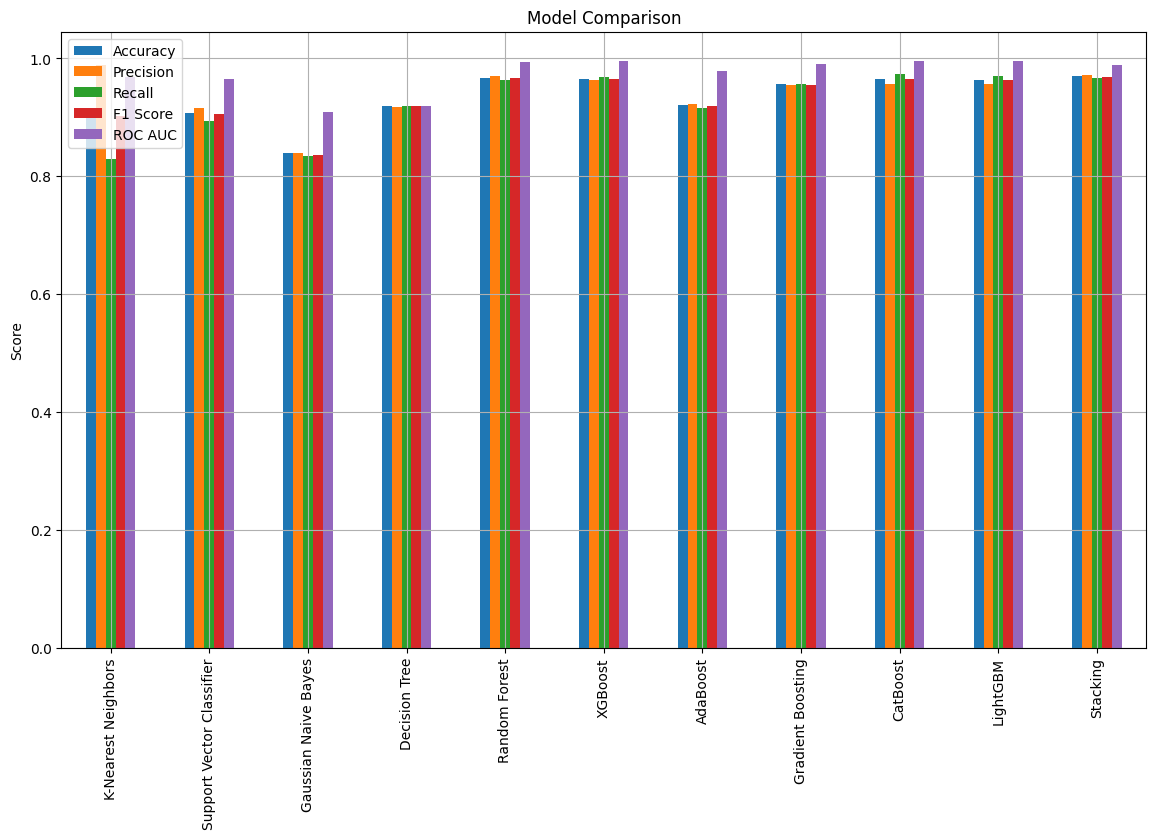

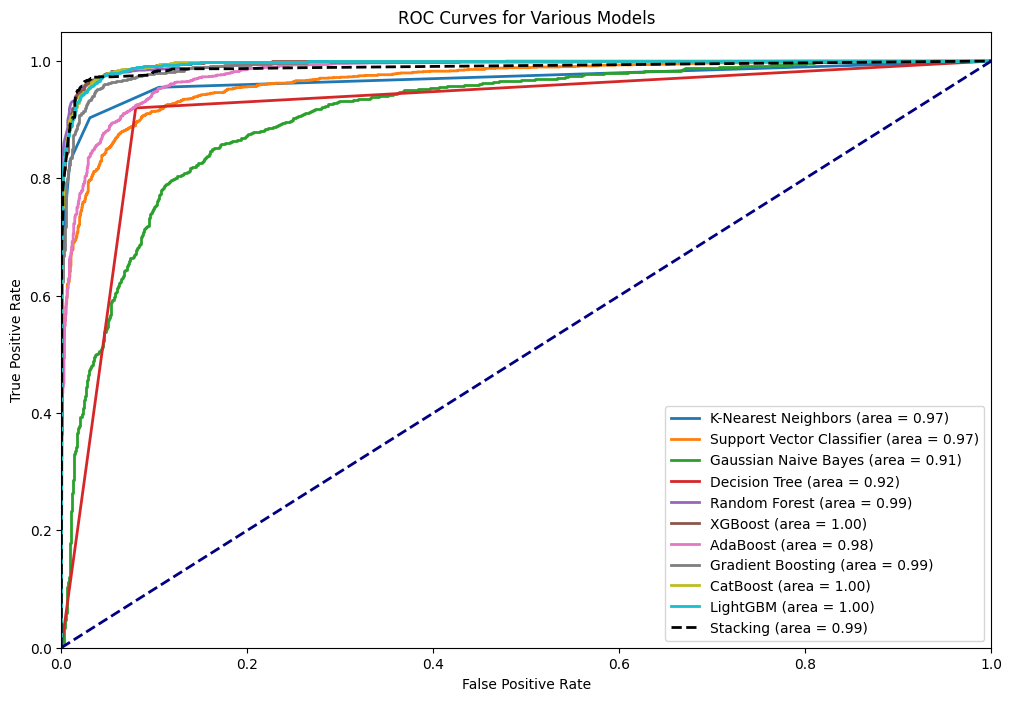

In [ ]:
# Collecting performance metrics for all models
performance_metrics = pd.DataFrame(results).T
# add stacking_results tothe performance_metrics as a column
performance_metrics.loc['Stacking'] = stacking_results

# Plotting the performance metrics
performance_metrics.plot(kind='bar', figsize=(14,8), title='Model Comparison', grid=True)
plt.ylabel('Score')
plt.show()

# Plotting ROC Curves for all models
plt.figure(figsize=(12,8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled_smote)[:,1]
    fpr, tpr, _ = roc_curve(y_test_smote, y_pred_proba)
    roc_auc = roc_auc_score(y_test_smote, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

# Adding ROC curve for stacking model
y_pred_proba_stack = stacking_model.predict_proba(X_test_scaled_smote)[:,1]
fpr_stack, tpr_stack, _ = roc_curve(y_test_smote, y_pred_proba_stack)
roc_auc_stack = roc_auc_score(y_test_smote, y_pred_proba_stack)
plt.plot(fpr_stack, tpr_stack, lw=2, label=f'Stacking (area = {roc_auc_stack:.2f})', color='black', linestyle='--')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc="lower right")
plt.show()
